# Race Detection

## Data Loading

In [33]:
import pandas as pd

In [34]:
Data_dir = "croped_images"
split = 0.7
w_img = h_img = 198
Gender = {0: 'male', 1: 'female'}
Gender_map = dict((g, i) for i, g in Gender.items())
Race = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
Race_map = dict((r, i) for i, r in Race.items())

Gender, Gender_map, Race, Race_map

({0: 'male', 1: 'female'},
 {'male': 0, 'female': 1},
 {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'},
 {'white': 0, 'black': 1, 'asian': 2, 'indian': 3, 'others': 4})

In [35]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), Gender[int(gender)], Race[int(race)]
    except Exception as e:
        print(filepath)
        return None, None, None

In [36]:
import glob
import os

In [37]:
files = glob.glob(os.path.join(Data_dir, "*.jpg"))

In [38]:
# from PIL import Image
# 
# def is_grey_scale(img_path):
#     img = Image.open(img_path).convert('RGB')
#     w, h = img.size
#     for i in range(w):
#         for j in range(h):
#             r, g, b = img.getpixel((i,j))
#             if r != g != b: 
#                 return False
#     return True

In [39]:
# for i in files:
# #     x = is_grey_scale(i)
#     im = Image.open(i)
#     im = im.resize((w_img, h_img))
#     im = np.array(im)/255
#     if len(im.shape)<3:
#         print(i, 'is')
#         im.resize((w_img, h_img, 3))
#         print(im.shape)
#     elif im.shape[2] != 3:
#         print(i, 'is', im.shape[2])
#         im.resize((w_img, h_img, 3))
#         print(im.shape)

In [40]:
attributes = list(map(parse_filepath, files))

croped_images\61_3_3_20170109150557335.jpg


In [41]:
df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['age', 'gender', 'race', 'file']
df = df.dropna()
df

,age,gender,race,file
0,39.0,female,asian,croped_images\39_1_2_20170103182754641.jpg
1,39.0,female,asian,croped_images\39_1_2_20170103183301786.jpg
2,39.0,female,asian,croped_images\39_1_2_20170103183338179.jpg
3,39.0,female,asian,croped_images\39_1_2_20170105001325620.jpg
4,39.0,female,asian,croped_images\39_1_2_20170105170215020.jpg
...,...,...,...,...
7339,9.0,female,indian,croped_images\9_1_3_20161220222856346.jpg
7340,9.0,female,indian,croped_images\9_1_3_20170104222949455.jpg
7341,9.0,female,others,croped_images\9_1_4_20170103200637399.jpg
7342,9.0,female,others,croped_images\9_1_4_20170103200814791.jpg


In [42]:
df.describe()

,age
count,7343.000000
mean,52.392619
std,17.045691
min,7.000000
25%,45.000000
50%,53.000000
75%,62.000000
max,85.000000


In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

## Data Exploration & Visualization

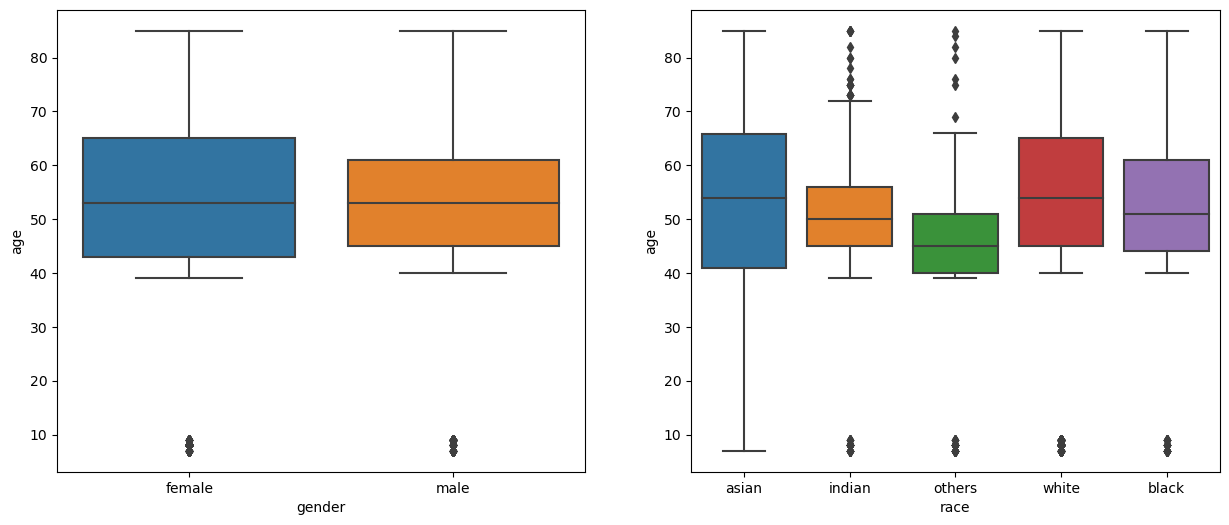

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
_ = sns.boxplot(data=df, x='gender', y='age', ax=ax1)
_ = sns.boxplot(data=df, x='race', y='age', ax=ax2)

<AxesSubplot:xlabel='gender', ylabel='age'>

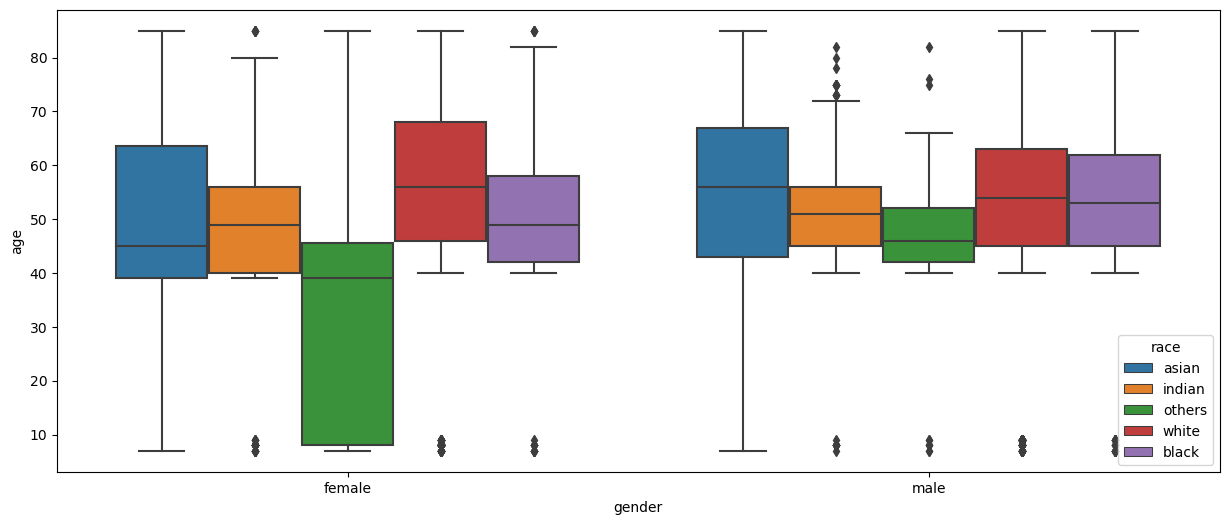

In [45]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='gender', y='age', hue='race')

<AxesSubplot:xlabel='race,gender'>

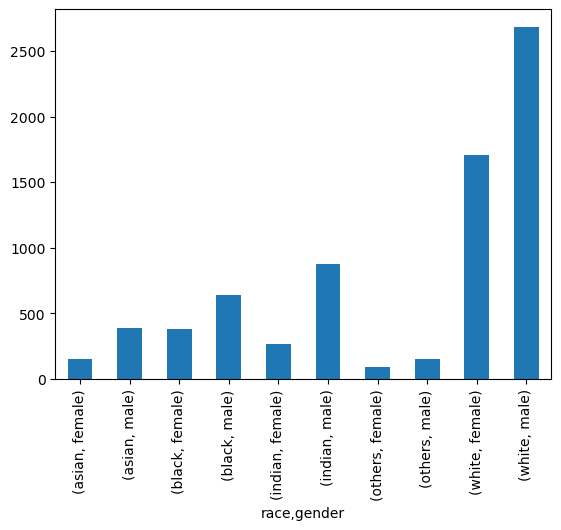

In [46]:
df.groupby(by=['race', 'gender'])['age'].count().plot(kind='bar')

<AxesSubplot:>

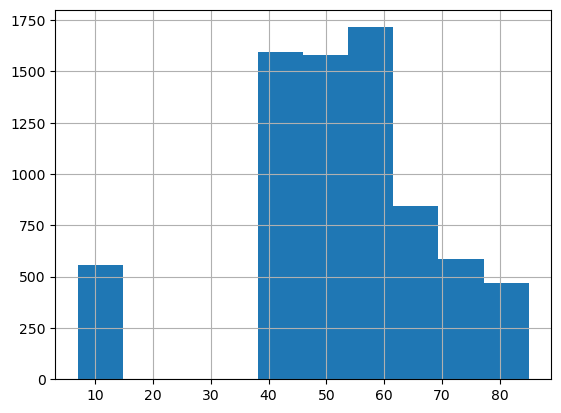

In [47]:
df['age'].hist()

In [48]:
df['age'].describe()

count    7343.000000
mean       52.392619
std        17.045691
min         7.000000
25%        45.000000
50%        53.000000
75%        62.000000
max        85.000000
Name: age, dtype: float64

In [49]:
# df = df[(df['age'] > 10) & (df['age'] < 65)]

## Data Preprocessing

In [50]:
import numpy as np

In [51]:
perm = np.random.permutation(len(df))
train_len = int(len(df) * split)
train = perm[:train_len]
test = perm[train_len:]

train_len = int(train_len * 0.7)
train, val = train[:train_len], train[train_len:]

df['gender_id'] = df['gender'].map(lambda gender: Gender_map[gender])
df['race_id'] = df['race'].map(lambda race: Race_map[race])

max_age = df['age'].max()

In [52]:
from keras.utils import to_categorical
from PIL import Image

In [53]:
def data_gen(df, indices, training, batch_sz):
    images = []
    races = []
    genders = []
    ages = []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, age, race, gender = r['file'], r['age'], r['race_id'], r['gender_id']
            image = Image.open(file)
            image = image.resize((w_img, h_img))
            image = np.array(image)/255
#             if len(image.shape)<3:
#                 image.resize((w_img, h_img, 3))
#             elif image.shape[2] != 3:
#                 image.resize((w_img, h_img, 3))
# #             print(image.shape, file)
            images.append(image)
            ages.append(age / max_age)
            races.append(to_categorical(race, len(Race_map)))
            genders.append(to_categorical(gender, 2))
            if len(images)>=batch_sz:
                yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
#                 print(np.shape(images), np.shape(ages), np.shape(races), np.shape(genders))
                images = []
                races = []
                genders = []
                ages = []
        if not training:
            break

## Model

In [54]:
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from keras.optimizers import Adam
from keras.models import Model

In [55]:
print(len(Race_map), len(Gender_map))

5 2


In [56]:
input_1 = Input(shape=(h_img, w_img, 3))
conv_1 = Conv2D(filters=32, kernel_size=3, activation='relu')(input_1)
conv_1 = BatchNormalization()(conv_1)
conv_1 = MaxPool2D()(conv_1)

conv_2 = Conv2D(filters=64, kernel_size=3, activation='relu')(conv_1)
conv_2 = BatchNormalization()(conv_2)
conv_2 = MaxPool2D()(conv_2)

conv_3 = Conv2D(filters=128, kernel_size=3, activation='relu')(conv_2)
conv_3 = BatchNormalization()(conv_3)
conv_3 = MaxPool2D()(conv_3)

conv_4 = Conv2D(filters=256, kernel_size=3, activation='relu')(conv_3)
conv_4 = BatchNormalization()(conv_4)
conv_4 = MaxPool2D()(conv_4)

conv_5 = Conv2D(filters=256, kernel_size=3, activation='relu')(conv_4)
conv_5 = BatchNormalization()(conv_5)
conv_5 = MaxPool2D()(conv_5)

gmax = GlobalMaxPool2D()(conv_5)

age = Dense(units=128, activation='relu')(gmax)
age = Dense(units=1, activation='sigmoid', name='age-output')(age)

race = Dense(units=128, activation='relu')(gmax)
race = Dense(units=len(Race_map), activation='softmax', name='race-output')(race)

gender = Dense(units=128, activation='relu')(gmax)
gender = Dense(units=len(Gender_map), activation='softmax', name='gender-output')(gender)

model = Model(inputs=input_1, outputs=[age, race, gender])
model.compile(optimizer='rmsprop',loss={'age-output': 'mse', 'race-output': 'categorical_crossentropy', 'gender-output': 'categorical_crossentropy'},
             loss_weights={'age-output': 2, 'race-output': 1.5, 'gender-output': 1},
             metrics={'age-output': 'mae', 'race-output': 'accuracy', 'gender-output': 'accuracy'})
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 198, 198, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 196, 196, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 196, 196, 32  128        ['conv2d_5[0][0]']               
 rmalization)                   )                                                           

In [57]:
from keras.callbacks import ModelCheckpoint
# import tensorflow as tf
batch_size = 128
valid_batch_size = 128

# train = tf.convert_to_tensor(train, dtype=tf.int64) 
# val = tf.convert_to_tensor(val, dtype=tf.int64) 

train_gen = data_gen(df, train, training=True, batch_sz=batch_size)
valid_gen = data_gen(df, val, training=True, batch_sz=valid_batch_size)

In [58]:
# callbacks = [
#     ModelCheckpoint("./model_checkpoint", monitor='val_loss')
# ]

history = model.fit(train_gen,
                    steps_per_epoch=len(train)//batch_size,
                    epochs=100,
#                     callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(val)//valid_batch_size)

Epoch 1/100
28/28 [==============================] - 27s 923ms/step - loss: 3.5253 - age-output_loss: 0.0901 - race-output_loss: 1.6226 - gender-output_loss: 0.9113 - age-output_mae: 0.2370 - race-output_accuracy: 0.5575 - gender-output_accuracy: 0.6225 - val_loss: 2.7499 - val_age-output_loss: 0.0450 - val_race-output_loss: 1.3396 - val_gender-output_loss: 0.6506 - val_age-output_mae: 0.1586 - val_race-output_accuracy: 0.5872 - val_gender-output_accuracy: 0.6510
Epoch 2/100
28/28 [==============================] - 16s 597ms/step - loss: 2.3819 - age-output_loss: 0.0615 - race-output_loss: 1.1033 - gender-output_loss: 0.6041 - age-output_mae: 0.1915 - race-output_accuracy: 0.6194 - gender-output_accuracy: 0.7001 - val_loss: 2.6886 - val_age-output_loss: 0.0415 - val_race-output_loss: 1.3045 - val_gender-output_loss: 0.6490 - val_age-output_mae: 0.1501 - val_race-output_accuracy: 0.5853 - val_gender-output_accuracy: 0.6510
Epoch 3/100
28/28 [==============================] - 16s 580ms/s

28/28 [==============================] - 17s 624ms/step - loss: 0.3200 - age-output_loss: 0.0203 - race-output_loss: 0.1278 - gender-output_loss: 0.0877 - age-output_mae: 0.1096 - race-output_accuracy: 0.9587 - gender-output_accuracy: 0.9710 - val_loss: 2.3205 - val_age-output_loss: 0.0344 - val_race-output_loss: 1.1515 - val_gender-output_loss: 0.5244 - val_age-output_mae: 0.1320 - val_race-output_accuracy: 0.7318 - val_gender-output_accuracy: 0.8529
Epoch 19/100
28/28 [==============================] - 17s 625ms/step - loss: 0.2168 - age-output_loss: 0.0189 - race-output_loss: 0.0607 - gender-output_loss: 0.0881 - age-output_mae: 0.1074 - race-output_accuracy: 0.9827 - gender-output_accuracy: 0.9735 - val_loss: 2.1475 - val_age-output_loss: 0.0319 - val_race-output_loss: 1.1008 - val_gender-output_loss: 0.4325 - val_age-output_mae: 0.1328 - val_race-output_accuracy: 0.7428 - val_gender-output_accuracy: 0.8665
Epoch 20/100
28/28 [==============================] - 18s 655ms/step - loss

28/28 [==============================] - 17s 608ms/step - loss: 0.0765 - age-output_loss: 0.0115 - race-output_loss: 0.0274 - gender-output_loss: 0.0124 - age-output_mae: 0.0840 - race-output_accuracy: 0.9919 - gender-output_accuracy: 0.9950 - val_loss: 3.0180 - val_age-output_loss: 0.0343 - val_race-output_loss: 1.5438 - val_gender-output_loss: 0.6339 - val_age-output_mae: 0.1344 - val_race-output_accuracy: 0.7728 - val_gender-output_accuracy: 0.8639
Epoch 36/100
28/28 [==============================] - 17s 607ms/step - loss: 0.1522 - age-output_loss: 0.0106 - race-output_loss: 0.0606 - gender-output_loss: 0.0401 - age-output_mae: 0.0802 - race-output_accuracy: 0.9810 - gender-output_accuracy: 0.9900 - val_loss: 3.2492 - val_age-output_loss: 0.0346 - val_race-output_loss: 1.6968 - val_gender-output_loss: 0.6348 - val_age-output_mae: 0.1353 - val_race-output_accuracy: 0.7344 - val_gender-output_accuracy: 0.8724
Epoch 37/100
28/28 [==============================] - 17s 612ms/step - loss

28/28 [==============================] - 16s 581ms/step - loss: 0.0430 - age-output_loss: 0.0079 - race-output_loss: 0.0129 - gender-output_loss: 0.0077 - age-output_mae: 0.0697 - race-output_accuracy: 0.9964 - gender-output_accuracy: 0.9978 - val_loss: 3.9355 - val_age-output_loss: 0.0347 - val_race-output_loss: 2.0219 - val_gender-output_loss: 0.8332 - val_age-output_mae: 0.1349 - val_race-output_accuracy: 0.7591 - val_gender-output_accuracy: 0.8652
Epoch 53/100
28/28 [==============================] - 16s 593ms/step - loss: 0.1128 - age-output_loss: 0.0080 - race-output_loss: 0.0426 - gender-output_loss: 0.0327 - age-output_mae: 0.0700 - race-output_accuracy: 0.9872 - gender-output_accuracy: 0.9902 - val_loss: 3.4209 - val_age-output_loss: 0.0324 - val_race-output_loss: 1.8036 - val_gender-output_loss: 0.6506 - val_age-output_mae: 0.1278 - val_race-output_accuracy: 0.7793 - val_gender-output_accuracy: 0.8984
Epoch 54/100
28/28 [==============================] - 16s 588ms/step - loss

28/28 [==============================] - 16s 583ms/step - loss: 0.0476 - age-output_loss: 0.0065 - race-output_loss: 0.0134 - gender-output_loss: 0.0144 - age-output_mae: 0.0631 - race-output_accuracy: 0.9953 - gender-output_accuracy: 0.9964 - val_loss: 4.5907 - val_age-output_loss: 0.0272 - val_race-output_loss: 2.4033 - val_gender-output_loss: 0.9313 - val_age-output_mae: 0.1185 - val_race-output_accuracy: 0.7656 - val_gender-output_accuracy: 0.8789
Epoch 70/100
28/28 [==============================] - 16s 583ms/step - loss: 0.0621 - age-output_loss: 0.0061 - race-output_loss: 0.0264 - gender-output_loss: 0.0102 - age-output_mae: 0.0615 - race-output_accuracy: 0.9916 - gender-output_accuracy: 0.9969 - val_loss: 4.5402 - val_age-output_loss: 0.0282 - val_race-output_loss: 2.3331 - val_gender-output_loss: 0.9842 - val_age-output_mae: 0.1206 - val_race-output_accuracy: 0.7695 - val_gender-output_accuracy: 0.8750
Epoch 71/100
28/28 [==============================] - 16s 584ms/step - loss

28/28 [==============================] - 17s 611ms/step - loss: 0.0850 - age-output_loss: 0.0051 - race-output_loss: 0.0391 - gender-output_loss: 0.0163 - age-output_mae: 0.0557 - race-output_accuracy: 0.9897 - gender-output_accuracy: 0.9955 - val_loss: 4.8503 - val_age-output_loss: 0.0284 - val_race-output_loss: 2.2677 - val_gender-output_loss: 1.3920 - val_age-output_mae: 0.1210 - val_race-output_accuracy: 0.7747 - val_gender-output_accuracy: 0.8665
Epoch 87/100
28/28 [==============================] - 17s 609ms/step - loss: 0.0229 - age-output_loss: 0.0048 - race-output_loss: 0.0042 - gender-output_loss: 0.0069 - age-output_mae: 0.0541 - race-output_accuracy: 0.9983 - gender-output_accuracy: 0.9978 - val_loss: 4.6612 - val_age-output_loss: 0.0307 - val_race-output_loss: 2.2852 - val_gender-output_loss: 1.1720 - val_age-output_mae: 0.1242 - val_race-output_accuracy: 0.7780 - val_gender-output_accuracy: 0.8724
Epoch 88/100
28/28 [==============================] - 17s 609ms/step - loss

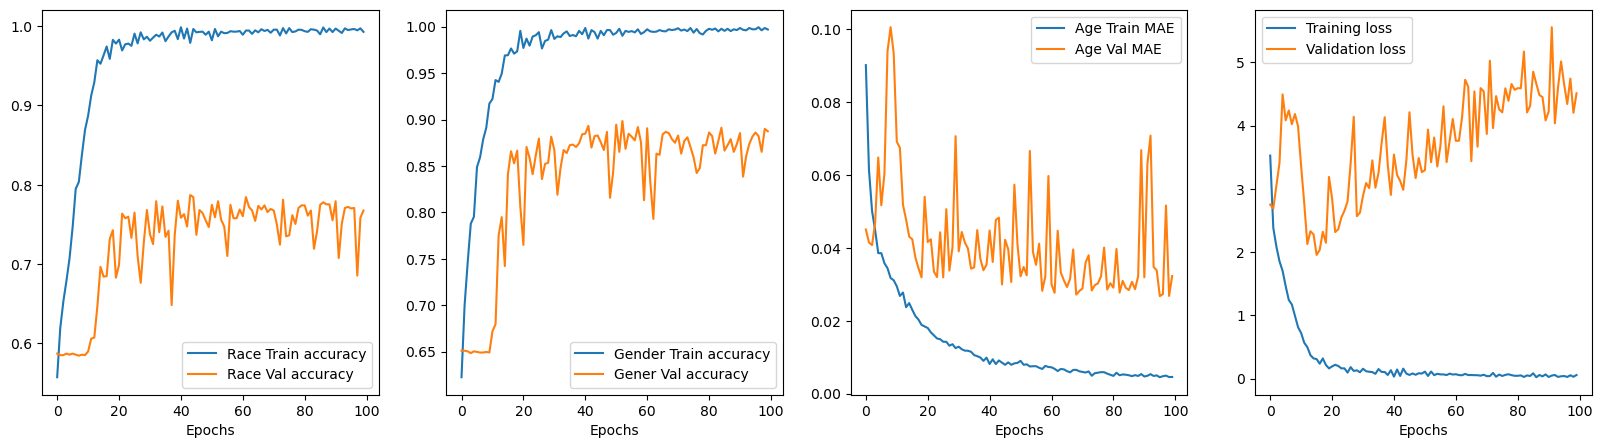

In [59]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].plot(history.history['race-output_accuracy'], label='Race Train accuracy')
axes[0].plot(history.history['val_race-output_accuracy'], label='Race Val accuracy')
axes[0].set_xlabel('Epochs')
axes[0].legend()

axes[1].plot(history.history['gender-output_accuracy'], label='Gender Train accuracy')
axes[1].plot(history.history['val_gender-output_accuracy'], label='Gener Val accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend()

axes[2].plot(history.history['age-output_loss'], label='Age Train MAE')
axes[2].plot(history.history['val_age-output_loss'], label='Age Val MAE')
axes[2].set_xlabel('Epochs')
axes[2].legend()  

axes[3].plot(history.history['loss'], label='Training loss')
axes[3].plot(history.history['val_loss'], label='Validation loss')
axes[3].set_xlabel('Epochs')
axes[3].legend()

In [60]:
test_gen = data_gen(df, test, training=False, batch_sz=128)
dict(zip(model.metrics_names, model.evaluate(test_gen, steps=len(test)//128)))

17/17 [==============================] - 12s 718ms/step - loss: 4.7585 - age-output_loss: 0.0323 - race-output_loss: 2.3082 - gender-output_loss: 1.2315 - age-output_mae: 0.1294 - race-output_accuracy: 0.7597 - gender-output_accuracy: 0.8764


{'loss': 4.758482933044434,
 'age-output_loss': 0.03231508657336235,
 'race-output_loss': 2.3082382678985596,
 'gender-output_loss': 1.23149573802948,
 'age-output_mae': 0.12935149669647217,
 'race-output_accuracy': 0.759650707244873,
 'gender-output_accuracy': 0.8763786554336548}

In [61]:
test_gen = data_gen(df, test, training=False, batch_sz=128)
x_test, (age_true, race_true, gender_true)= next(test_gen)
age_pred, race_pred, gender_pred = model.predict_on_batch(x_test)

In [62]:
race_true, gender_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1)
race_pred, gender_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)
age_true = age_true * max_age
age_pred = age_pred * max_age

In [63]:
from sklearn.metrics import classification_report
print("Classification report for race")
print(classification_report(race_true, race_pred))

print("\nClassification report for gender")
print(classification_report(gender_true, gender_pred))

Classification report for race
              precision    recall  f1-score   support

           0       0.87      0.89      0.88        76
           1       0.70      0.70      0.70        20
           2       0.40      0.25      0.31         8
           3       0.81      0.65      0.72        20
           4       0.11      0.25      0.15         4

    accuracy                           0.77       128
   macro avg       0.58      0.55      0.55       128
weighted avg       0.78      0.77      0.77       128


Classification report for gender
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        85
           1       0.84      0.74      0.79        43

    accuracy                           0.87       128
   macro avg       0.86      0.84      0.85       128
weighted avg       0.87      0.87      0.86       128



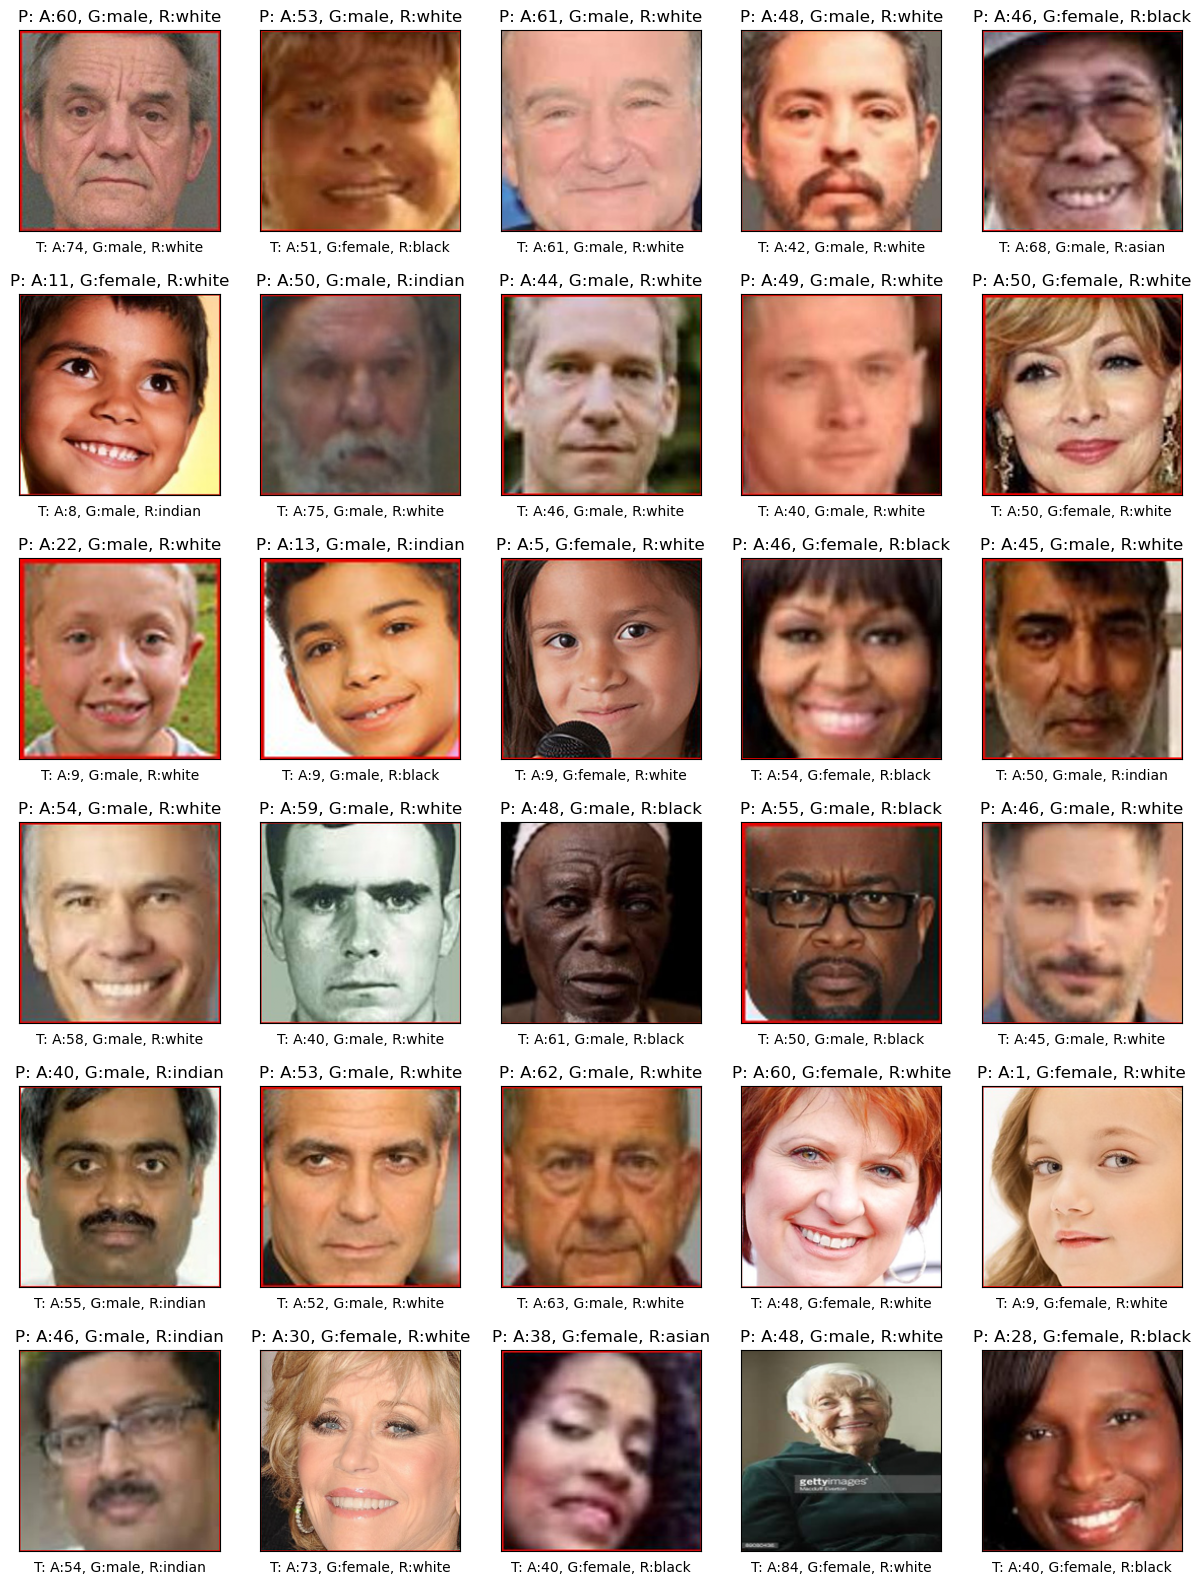

In [64]:
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('P: A:{}, G:{}, R:{}'.format(int(age_pred[img_idx]), Gender[gender_pred[img_idx]], Race[race_pred[img_idx]]))
    ax.set_xlabel('T: A:{}, G:{}, R:{}'.format(int(age_true[img_idx]), Gender[gender_true[img_idx]], Race[race_true[img_idx]]))
    ax.set_xticks([])
    ax.set_yticks([])